In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display


# Gravity gradient torque from Neptune
mu = 6.836529e15
R = 27e6
boom_mass = 6
boom_length = 32.5
additional_boom_end_mass = 0.234 * 2

Iz = (4 * ((boom_mass * (boom_length ** 2)) / 3) + (additional_boom_end_mass * (boom_length ** 2)))
Ix = Iz / 2
Iy = Iz / 2
theta_x = np.pi/2
theta_y = np.pi/2

Tgx = 3 * (mu / (2 * R ** 3)) * np.abs(Iz - Iy)
Tgy = 3 * (mu / (2 * R ** 3)) * np.abs(Iz - Ix)
print(f"Tgy: {Tgy}, Tgx: {Tgx}")

total_momentum_storage = (Tgy + Tgx) * 2.5 * 60 * 60 * 24
print("Total momentum storage over the course of the mission:", total_momentum_storage)


Tgy: 0.0023299854156350022, Tgx: 0.0023299854156350022
Total momentum storage over the course of the mission: 1006.553699554321


In [2]:

# Gravity gradient torque from Triton
mu = 2.139e22 * 6.67430e-11
R = (3e3 + 1353.39393) * 1000
boom_mass = 6
boom_length = 32.5
additional_boom_end_mass = 0.234 * 2

Iz = (4 * ((boom_mass * boom_length ** 2) / 3) + (additional_boom_end_mass * boom_length ** 2))
Ix = Iz / 2
Iy = Iz / 2
theta_x = np.pi/2
theta_y = np.pi/2

Tgx = 3 * (mu / (2 * R ** 3)) * np.abs(Iz - Iy)
Tgy = 3 * (mu / (2 * R ** 3)) * np.abs(Iz - Ix)
print(f"Tgy: {Tgy}, Tgx: {Tgx}")

total_momentum_storage = (Tgy + Tgx) * 2.5 * 60 * 60 * 24
print("Total momentum storage over the course of the mission:", total_momentum_storage)

Tgy: 0.00011607573458416634, Tgx: 0.00011607573458416634
Total momentum storage over the course of the mission: 50.14471734035986


In [3]:
# Calculation for torque producted from electrospray thrusters on one axis

force_per_thruster_unit = 5e-6
desired_torque_output = Tgy * 2
number_of_units_per_array = desired_torque_output / (force_per_thruster_unit * boom_length * 4)
print(number_of_units_per_array) # ~ 13
ethruster_array_mass = 0.234
ethruster_array_power_usage = 130e-3

print(ethruster_array_mass * 8) # total ethrusters system mass
print(ethruster_array_power_usage * 8) # total power consumption for ethrusters


0.3571561064128195
1.872
1.04


In [4]:
def allocation(a, I, esp_tau_max, cmg_tau_max, cmg_l_max, e_arcmin, timestep, cmg_l):
    # a input in rad/s^2
    # cmg_unload_rate defines the percent of fastest momentum dump rate that will be tolerated as a percentage of max unload rate
    # set percent CMG and ESP utilization to 0
    empty_dict = dict()
    usage = dict()
    usage['esp'] = 0.0
    usage['cmg'] = 0.0
    usage['saturate'] = 0.0

    # calculate required tau, and max ESP tau
    tau = np.abs(I * a)

    usage['cmg_l'] = cmg_l

    cmg_tau_avail = ((cmg_l_max - cmg_l) / timestep) / cmg_tau_max

    # calculate available cmg tau, make sure achievable
    if cmg_tau_avail > 0.002:
        cmg_tau_avail = 0.002

    sign = 1

    # if within suitable error and tau is low use esps and unload, change to make sure momentum is never negative?
    if np.abs(e_arcmin) < 0.2 and tau < (0.1) * esp_tau_max:
        usage['esp'] = (tau + cmg_tau_avail) / esp_tau_max
        usage['cmg'] = cmg_tau_avail / cmg_tau_max
        sign = -1
    # if tau achievable with just esp
    elif tau <= esp_tau_max:
        usage['esp'] = tau / esp_tau_max
        usage['cmg'] = 0.0
    # if tau is achievable
    elif tau > esp_tau_max and tau < (esp_tau_max + cmg_tau_avail):
        usage['esp'] = 1.0
        usage['cmg'] = (tau - esp_tau_max) / cmg_tau_max
    # if tau is greater than available tau
    elif tau > (esp_tau_max + cmg_tau_avail):
        usage['saturate'] += 1
        usage['esp'] = 1.0
        usage['cmg'] = cmg_tau_avail / cmg_tau_max
    
    usage['cmg_l'] = sign * usage['cmg'] * cmg_tau_max * timestep + cmg_l # update momentum storage

    return usage

In [5]:
cmg_tau_max = 0.002
cmg_l_max = 0.02
rad_conversion = 60 * 180 / np.pi # radian-to-arcminute conversion

array_size = 5

n = 300 # time points to plot
error = np.zeros(n) # array to store error
alpha = np.zeros(n) # array to store angular acceleration
tf = 300.0 # final time
SP_start = 2.0 # time of set point change
ci = 50

esp_tau_max = (force_per_thruster_unit * boom_length * array_size)

t = np.linspace(0,tf,n) # create time vector

tstep = tf / n

SPs = np.random.randint(0, 2, ci)
final_e = np.ones(n // ci)

cmg_l = np.zeros(n)
error = np.zeros(n)


def process(y,t,u):
	Kp = 4.0
	taup = 3.0
	thetap = 1.0
	if t<(thetap+SP_start):
		dydt = 0.0  # time delay
	else:
		dydt = (1.0/taup) * (-y + Kp * u)
	return dydt

def pidPlot(Kc,tauI,tauD):
	t = np.linspace(0,tf,n) # create time vector
	P= np.zeros(n)          # initialize proportional term
	I = np.zeros(n)         # initialize integral term
	D = np.zeros(n)         # initialize derivative term
	e = np.zeros(n)         # initialize error
	OP = np.zeros(n)        # initialize controller output
	PV = np.zeros(n)        # initialize process variable
	SP = np.zeros(n)        # initialize setpoint

	# alpha_x = Tgx / Ix
	# delta_theta = 0.5 * alpha_x * ((tf / n) ** 2)
	# delta_theta_arcmin = delta_theta * 216e2 / (2 * np.pi) 
	SP_step = int(SP_start/(tf/(n-1))+1) # setpoint start
	SP[0:SP_step] = 0.0     # define setpoint
	SP[SP_step:n] = 4.0     # step up
	y0 = 0.0                # initial condition

	

	max_possible_tau = force_per_thruster_unit * boom_length # calculate max possible torque from ACS
	j = 0 # saturation counter

	#allocation: allocation(a, I, esp_thrust_max, cmg_tau_max, cmg_l_max, boom_length, e_arcmin, timestep, cmg_l)

	for i in range(n):	
		SP[i] = SPs[i // ci]
	# loop through all time steps
	for i in range(1,n):
		# simulate process for one time step
		ts = [t[i-1],t[i]]         # time interval -- should this be calculated every time?
		y = odeint(process,y0,ts,args=(OP[i-1],))  # compute next step
		temp = y0
		y0 = y[1]                  # record new initial condition
	
		# arcmin -> rad: * np.pi / (60 * 180)

		# calculate new OP with PID
		#PV[i] = y[1]               # record PV
		a = (((y0 - temp) / tstep) - ((temp - PV[i-1]) / tstep)) / tstep # comparing slope of current timestep and previous timestep to find angular acceleration
		alpha[i] = a
		tau = Iz * a
		
		alloc = allocation(alpha[i], Iz, esp_tau_max, cmg_tau_max, cmg_l_max, error[i], tstep, cmg_l[i])

		cmg_l[i] = alloc['cmg'] * cmg_tau_max + cmg_l[i-1]

		PV[i] = temp + 0.5 * (alloc['cmg'] * cmg_tau_max + alloc['esp'] * esp_tau_max) * (tstep ** 2) # record PV: use kinematic formulas to calculate angular displacement

		e[i] = SP[i] - PV[i]       # calculate error = SP - PV
		error[i] = e[i] * rad_conversion # store error in arcmin
		dt = t[i] - t[i-1]         # calculate time step
		P[i] = Kc * e[i]           # calculate proportional term
		I[i] = I[i-1] + (Kc/tauI) * e[i] * dt  # calculate integral term
		D[i] = -Kc * tauD * (PV[i]-PV[i-1])/dt # calculate derivative term
		OP[i] = P[i] + I[i] + D[i] # calculate new controller output

	
	# plot PID response
	plt.figure(1,figsize=(15,7))
	plt.subplot(2,2,1)
	plt.plot(t,SP,'k-',linewidth=2,label='Setpoint (SP)')
	plt.plot(t,PV,'r-',linewidth=2,label='Process Variable (PV)')
	plt.legend(loc='best')
	plt.subplot(2,2,2)
	plt.plot(t,P,'g.-',linewidth=2,label=r'Proportional = $K_c \; e(t)$')
	plt.plot(t,I,'b-',linewidth=2,label=r'Integral = $\frac{K_c}{\tau_I} \int_{i=0}^{n_t} e(t) \; dt $')
	plt.plot(t,D,'r--',linewidth=2,label=r'Derivative = $-K_c \tau_D \frac{d(PV)}{dt}$')    
	plt.legend(loc='best')
	plt.subplot(2,2,3)
	plt.plot(t,e,'m--',linewidth=2,label='Error (e=SP-PV)')
	plt.legend(loc='best')
	plt.subplot(2,2,4)
	plt.plot(t,OP,'b--',linewidth=2,label='Controller Output (OP)')
	plt.legend(loc='best')
	plt.xlabel('time')

Kc_slide = wg.FloatSlider(value=0.24,min=-0.2,max=1.0,step=0.0001) # 0.25
tauI_slide = wg.FloatSlider(value=2.46,min=0.01,max=5.0,step=0.0001) # 4.00
tauD_slide = wg.FloatSlider(value=0.0,min=0.0,max=1.0,step=0.0001) # 0.00
wg.interact(pidPlot, Kc=Kc_slide, tauI=tauI_slide, tauD=tauD_slide)
print(np.max(final_e))

for i in range (0,300):
	print(cmg_l[i])

interactive(children=(FloatSlider(value=0.24, description='Kc', max=1.0, min=-0.2, step=0.0001), FloatSlider(v…

1.0
0.0
0.002
0.004
0.006
0.008
0.01
0.012
0.014
0.016
0.018000000000000002
0.020000000000000004
0.022000000000000006
0.024000000000000007
0.02600000000000001
0.02800000000000001
0.030000000000000013
0.032000000000000015
0.034000000000000016
0.03600000000000002
0.03800000000000002
0.04000000000000002
0.04200000000000002
0.044000000000000025
0.04600000000000003
0.04800000000000003
0.05000000000000003
0.05200000000000003
0.054000000000000034
0.056000000000000036
0.05800000000000004
0.06000000000000004
0.06200000000000004
0.06400000000000004
0.06600000000000004
0.06800000000000005
0.07000000000000005
0.07200000000000005
0.07400000000000005
0.07600000000000005
0.07800000000000006
0.08000000000000006
0.08200000000000006
0.08400000000000006
0.08600000000000006
0.08800000000000006
0.09000000000000007
0.09200000000000007
0.09400000000000007
0.09600000000000007
0.09800000000000007
0.10000000000000007
0.10200000000000008
0.10400000000000008
0.10600000000000008
0.10800000000000008
0.1100000000000

Observation window throughout 92.0% of mission.


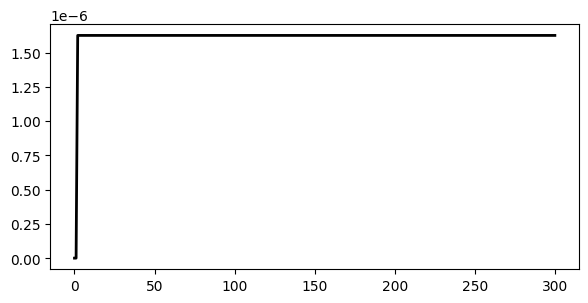

In [6]:
esp_tau = np.zeros(n)
cmg_tau = np.zeros(n)
cmg_l = np.zeros(n)



for i in range(1,n):
    esp_tau[i] = esp_tau_max * allocation(alpha[i], Iz, esp_tau_max, cmg_tau_max, cmg_l_max, error[i], tstep, cmg_l[i])['cmg_l']

    
a = allocation(alpha[50], Iz, esp_tau_max, cmg_tau_max, cmg_l_max, error[50], tstep, cmg_l[50])['esp']

acceptable_error_count = 0

for i in range(0,n):
    if error[i] < 0.4:
        acceptable_error_count += 1

error_percentage = (acceptable_error_count / n) * 100

print(f"Observation window throughout {error_percentage}% of mission.")

        

plt.figure(1,figsize=(15,7))
plt.subplot(2,2,1)
plt.plot(t,esp_tau,'k-',linewidth=2,label='test')
# plt.plot(t,cmg_tau,'r-',linewidth=2,label='CMG Utilization (Torque)')
# plt.xlabel("Time (seconds)")
# plt.ylabel("Torque (mNm)")
# plt.legend(bbox_to_anchor=(0.5, -0.3), loc='center', borderaxespad=0)
# plt.subplot(2,2,2)
# plt.plot(t,cmg_l,'r-',linewidth=2,label='CMG Angular Momentum')
# plt.ylabel("Angular Momentum (mNms)")
# plt.xlabel("Time (seconds)")
# plt.legend(bbox_to_anchor=(0.5, -0.3), loc='center', borderaxespad=0)
plt.show()
